In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep

from pandas_datareader import data as pdr
import pandas_ta as ta #commented out for me for now, I (Ben) had some dependency issues

import yfinance as yf
# import quandl as qd # not used, ignor ples
from backtesting import Backtest, Strategy

C:\Users\Staro\.virtualenvs\dsc190-FVH1D0fH\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
yf.pdr_override() # for use with pandas-datareader, optional

uncomment below if you need to update/generate your monthly and daily csv files.

In [3]:
# ticker = pd.read_csv('ticker.csv')['Ticker']
# tickers = ticker.to_list() # This is a list of all tickers in the SP500
# tickers = [x.replace('.','-') for x in tickers] # yahoo has '-' instead of '.' for tickers, eg BRK.B

# ## below is how I got monthly and daily pandas dataframes of all stocks in one huge dict.  
# monthly_sp500 = {}
# daily_sp500 = {}
# for tkr in tickers: # run all 500 at your own risk, it takes a while lol
# # for tkr in tickers[:10]:
#     print('Grabbing ' + tkr + " data!")
#     monthly_sp500[tkr] = pdr.get_data_yahoo(tkr, start="2010-01-01", interval = "1mo")
#     daily_sp500[tkr] = pdr.get_data_yahoo(tkr,start="2010-01-01")
#     sleep(.1) # not planning on ddos-ing yahoo today
# monthly_sp500['AAPL'] # take AAPL, for example

# ## everything in one stupid large dataframe
# sp500m = monthly_sp500[tickers[0]] # monthly
# sp500m['Name'] = tickers[0]

# sp500d = daily_sp500[tickers[0]] # daily
# sp500d['Name'] = tickers[0]

# # for tkr in tickers[1:10]:
# for tkr in tickers[1:]:
#     df1 = monthly_sp500[tkr] # monthly
#     df1['Name'] = tkr
#     sp500m = sp500m.append(df1)

#     df2 = daily_sp500[tkr] # daily
#     df2['Name'] = tkr
#     sp500d = sp500d.append(df2)

# sp500m.to_csv('SP500_monthly.csv') # run/uncomment some of these to save these to csv
# sp500d.to_csv('SP500_daily.csv')

In [4]:
# df = pd.read_csv('SP500_monthly.csv').infer_objects().dropna()
df = pd.read_csv('SP500_daily.csv').infer_objects().dropna()
# df = sp500m.infer_objects().dropna()#.reset_index() # dataframe of all we basically want, OHLC data w/ adjusted close. didnt set any ind
df

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.583586,493729600.0,AAPL
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.594968,601904800.0,AAPL
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.490066,552160000.0,AAPL
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.478067,477131200.0,AAPL
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.521136,447610800.0,AAPL
...,...,...,...,...,...,...,...,...
1365206,2021-03-04,23.020000,23.330000,22.389999,22.770000,22.770000,345900.0,NWS
1365207,2021-03-05,22.940001,23.549999,22.510000,23.500000,23.500000,515500.0,NWS
1365208,2021-03-08,23.500000,23.760000,22.980000,23.230000,23.230000,754500.0,NWS
1365209,2021-03-09,24.000000,24.459999,23.389999,23.799999,23.799999,632600.0,NWS


In [5]:
# j=1
# k=2
# # the 'midpoints' for each observe and hold period. midpoint in this context is where we switch from the observation period len=j to the holding period len=k
# j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS")
# j_end.strftime("%Y-%m-%d").to_list()[:10]

In [6]:
# pd.date_range(st+pd.DateOffset(days=j), et)

In [7]:
# def generate_momentum_returns(j=25,k=50):
def generate_daily_timetable(j,k):
    '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    j_end = pd.date_range(pd.to_datetime(df.Date.min())+pd.DateOffset(days=j), pd.to_datetime(df.Date.max()), freq=str(k)+"D") # the 'midpoints' for each observe and hold period. 
    j_start = j_end + pd.DateOffset(days=-j) # based on the midpoint, get the start point for each observe and hold period
    k_end = j_end + pd.DateOffset(days=k-1) # based on the midpoint, get the end point for each observe and hold period
    timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
    return timetable, j, k
timedf, j, k = generate_daily_timetable(10,10) 
print(timedf.shape[0])
timedf.head() ##NOTE THE K_END VALUE IS NO LONGER EQUAL TO THE NEXT MIDPOINT BUT OFFSET BY 1

408


,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-01-23
1,2010-01-14,2010-01-24,2010-02-02
2,2010-01-24,2010-02-03,2010-02-12
3,2010-02-03,2010-02-13,2010-02-22
4,2010-02-13,2010-02-23,2010-03-04


In [8]:
from itertools import chain
def get_daily_j(id=-1):
    jtimes = pd.DataFrame(list(chain.from_iterable(pd.date_range(timedf["j_start"],timedf["midpoint"]) for _,timedf in timedf.iterrows())), columns=("date",))
    jtimes['date'] = jtimes['date'].astype('datetime64[ns]')
    jtimes['period'] = (jtimes['date'].isin(timedf['midpoint'])).shift(1).cumsum().fillna(0).astype(int)
    df_ = df.copy()
    if 'date' not in df_.columns: 
        df_['date'] = pd.to_datetime(df_['Date'])
    df_['date'] = pd.to_datetime(df_['date'])
    df_ = df_.merge(jtimes, how='inner', left_on='date', right_on='date')
    if id==-1: 
        return df_ # this filters out periods that dont end prettily
    else:
        return df_[df_['period']==id].drop(columns='period')
# get_j_df = get_daily_j
def get_daily_k(id=-1):
    ktimes = pd.DataFrame(list(chain.from_iterable(pd.date_range(timedf["midpoint"],timedf["k_end"]) for _,timedf in timedf.iterrows())), columns=("date",))
    ktimes['date'] = ktimes['date'].astype('datetime64[ns]')
    ktimes['period'] = (ktimes['date'].isin(timedf['k_end'])).shift(1).cumsum().fillna(0).astype(int)
    df_ = df.copy()
    if 'date' not in df_.columns: 
        df_['date'] = pd.to_datetime(df_['Date'])
    df_['date'] = pd.to_datetime(df_['date'])
    df_ = df_.merge(ktimes, how='inner', left_on='date', right_on='date')
    if id==-1: 
        return df_ # this filters out periods that dont end prettily
    else:
        return df_[df_['period']==id].drop(columns='period')
# get_daily_j()#.period.plot()

In [9]:
# get_daily_j(0)

In [10]:
# def generate_timetable(j=1, k=2):
#     '''aims to generate the MONTHLY table of times for each observe/hold period. The midpoint in this context is where we switch from the observation period len=j to the holding period len=k'''
    
#     j_end = pd.date_range(st+pd.DateOffset(months=j*3), et, freq=str(k*3)+"MS") # the 'midpoints' for each observe and hold period. 
#     j_start = j_end + pd.DateOffset(months=-j*3) # based on the midpoint, get the start point for each observe and hold period
#     k_end = j_end + pd.DateOffset(months=k*3) # based on the midpoint, get the end point for each observe and hold period
#     timetable = pd.DataFrame({'j_start': j_start, 'midpoint': j_end, 'k_end': k_end}).infer_objects()
#     return timetable, j, k
# timedf, j, k = generate_timetable(3, 2)
# timedf.head()

In [11]:
# midpoint = timedf.iloc[0].midpoint

In [12]:
# def get_j_df(id=-1, j=j):
#     '''this should spit out a dataframe of data in the observational period j given specific id or midpoint value. 
#     if unspecified it throws all of them at you with an extra identifying column "periods"'''
#     if (id==-1): # not really sure why we need this but ill include it. this adds a sector column to the data for future filtering purposes if needed
#         df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
#         for i in timedf.index: 
#             # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
#             df_ = df[(timedf.iloc[i].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].midpoint)] # gets dates btw start and midpt
#             df_['period'] = i
#             df_i = pd.concat([df_i, df_])

#         return df_i
#     return df[(timedf.iloc[id].j_start <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].midpoint)] # gets dates btw start and midpt from table
# get_j_df(0)

In [13]:
# def get_k_df(id=-1, k=k):
#     '''this should spit out a dataframe of data in the holding period k given specific id or midpoint value. 
#     if unspecified it throws all of them at you with an extra identifying column "periods"'''
#     if (id==-1): # we can decide if this is useful later this adds a sector column to the data for future filtering purposes if needed
#         df_i = pd.DataFrame(columns=df.columns.to_list()+['period']) #dummy empty df
#         for i in timedf.index: 
#             # print(timedf.iloc[i].j_start,timedf.iloc[i].midpoint)
#             df_ = df[(timedf.iloc[i].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[i].k_end)] # gets dates btw midpt and end
#             df_['period'] = i
#             df_i = pd.concat([df_i, df_])

#         return df_i
#     return df[(timedf.iloc[id].midpoint <= pd.to_datetime(df['Date']))&(pd.to_datetime(df['Date']) <= timedf.iloc[id].k_end)] # gets dates btw midpt and end
# get_k_df()

# Data Analysis: using the above functions for building portfolios

In [14]:
timedf,j,k = generate_daily_timetable(j=20, k=20) # with j as 3 and k as 2
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-24,2010-02-12
1,2010-01-24,2010-02-13,2010-03-04
2,2010-02-13,2010-03-05,2010-03-24
3,2010-03-05,2010-03-25,2010-04-13
4,2010-03-25,2010-04-14,2010-05-03
...,...,...,...
199,2020-11-27,2020-12-17,2021-01-05
200,2020-12-17,2021-01-06,2021-01-25
201,2021-01-06,2021-01-26,2021-02-14
202,2021-01-26,2021-02-15,2021-03-06


In [15]:
df0 = get_daily_j(0).set_index('Name') # i dont know why, but you have to set index to name for the groupby's to work
df0['pct_change'] = df0['Adj Close'].groupby('Name').pct_change()
df0['cum_return'] = (df0['pct_change']+1).groupby('Name').cumprod().fillna(1)-1
df0['adj_close_shifted'] = df0['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
df0['adj_change'] = df0['Adj Close']/df0['adj_close_shifted'] #.bfill(0) 

features = df0.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False)
features

,Date,Open,High,Low,Close,Adj Close,Volume,date,pct_change,cum_return,adj_close_shifted,adj_change
Name,,,,,,,,,,,,
ZION,2010-01-22,18.070000,18.250000,17.120001,17.660000,15.432473,11289700.0,2010-01-22,-0.038126,0.324831,14.951853,1.032145
DPZ,2010-01-22,11.020000,11.120000,10.770000,11.070000,9.412185,731200.0,2010-01-22,0.003626,0.275346,9.709770,0.969352
HBAN,2010-01-22,4.420000,4.870000,4.250000,4.690000,3.451912,61227600.0,2010-01-22,0.035320,0.274457,3.164866,1.090698
KEY,2010-01-22,7.160000,7.490000,6.740000,7.250000,5.482886,27104500.0,2010-01-22,-0.012261,0.220538,5.112319,1.072485
RF,2010-01-22,6.800000,6.850000,6.490000,6.600000,5.211699,48623600.0,2010-01-22,-0.037901,0.217712,5.140628,1.013825
...,...,...,...,...,...,...,...,...,...,...,...,...
KLAC,2010-01-22,32.230000,32.380001,30.719999,30.860001,18.370413,7991300.0,2010-01-22,-0.060579,-0.164138,20.025291,0.917361
IPGP,2010-01-22,14.500000,15.250000,14.200000,14.290000,14.290000,347600.0,2010-01-22,0.049192,-0.177317,15.200000,0.940132
AMD,2010-01-22,8.550000,8.560000,7.820000,7.880000,7.880000,69136400.0,2010-01-22,-0.123470,-0.187629,9.010000,0.874584


In [16]:
# monthly_sp500['PYPL'].head() # TODO we should write about some of the issues of yahoofinance as a datasource, that should be sufficient

In [17]:
# this calculates the winner and loser tickers given n
n = 50
get_percents = lambda n: features.shape[0]//n+1 # this function gets us n percent number of tickers
winner_tickers = features[:get_percents(n)].index
winner_tickers

Index(['ZION', 'DPZ', 'HBAN', 'KEY', 'RF', 'FITB', 'ILMN', 'MGM', 'DAL',
       'CMA'],
      dtype='object', name='Name')

In [18]:
loser_tickers = features[-get_percents(n):].index
loser_tickers

Index(['GPN', 'LRCX', 'URI', 'EXPE', 'MU', 'KLAC', 'IPGP', 'AMD', 'HWM',
       'TMUS'],
      dtype='object', name='Name')

In [19]:
# equally weight
weights = np.ones(get_percents(n))/(get_percents(n))

In [20]:
winner_df0 = df0.loc[winner_tickers.to_list()]
winner_df0 = winner_df0.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0) # 
winner_df0
# winner_df0.dot(weights) # gives us the percent change of the portfolios
winner_performance = (winner_df0.dot(weights)+1).cumprod() - 1 # gets cumulative return for a period
winner_performance

Date
2010-01-04    0.000000
2010-01-05    0.031945
2010-01-06    0.053023
2010-01-07    0.120271
2010-01-08    0.114697
2010-01-11    0.130331
2010-01-12    0.152065
2010-01-13    0.183348
2010-01-14    0.215212
2010-01-15    0.192947
2010-01-19    0.200450
2010-01-20    0.211102
2010-01-21    0.237902
2010-01-22    0.230396
dtype: float64

In [21]:
def get_cum_return(data):
    '''gets cumulative return based on adjusted closing price of all tickers in input dataframe'''
    df_ = data.set_index('Name')

    # df_['pct_change'] = df_['Adj Close'].groupby('Name').pct_change()
    df_['pct_change'] = df_['Adj Close'].groupby('Name').pct_change()
    df_['cum_return'] = (df_['pct_change']+1).groupby('Name').cumprod().fillna(1)-1
    df_['adj_close_shifted'] = df_['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
    df_['adj_change'] = df_['Adj Close']/df_['adj_close_shifted'] #.bfill(0) 
    df_['adj_close_shifted'] = df_['Adj Close'].groupby('Name').shift(3)#.bfill(0) # filing the value with the backfill TODO check this later
    df_['adj_change'] = df_['Adj Close']/df_['adj_close_shifted'] #.bfill(0) 
    
    return df_

def get_percents(n): 
    '''this function gets us n percent number of tickers'''
    return features.shape[0]//n+1

def get_portfolios(period=0, n=50):   
    '''returns the portfolios we want from a particular period'''
    ## Gets the portfolio(s) in question we want to look at
    data = get_cum_return(get_daily_j(period))
    features = data.groupby('Name').tail(1).sort_values(['cum_return'], ascending=False) # sorts tickers by cumulative return

    winner_tickers = features[:get_percents(n)].index # we get the top/bottom n percent tickers
    loser_tickers = features[-get_percents(n):].index # only winner and loser portfolios for now, we could expand later
    # TODO add more portfolios if we have time
    # print(len(winner_tickers), len(loser_tickers))
    print('.', end='')
    return (winner_tickers.to_list(), loser_tickers.to_list())

def get_portfolio_performance(period=0, n=2, weights=None, hold=False):
    '''Gets all portfolios' cumulative return performance based on n period 
    keyword args:
    period      -- the nth period of data we are looking at, default 0
    portfolio   -- the particular type of portfolio we want to be looking at (winner or loser, etc) default winner/momentum
    n           -- the percentage of tickers we want to be looking at
    weights     -- how to weight the portfolio values. if unspecified (None) we assume equal weighting in the portfolio
    hold        -- if true returns the performance evaluation of the holding period k, else returns the performance of the observation period j
    '''
    winner_tickers, loser_tickers = get_portfolios(period, n)

    ## evaluates the performance of portfolios on either hold or observational data
    eval_df = get_cum_return(get_k_df(period)) if hold else get_cum_return(get_daily_j(period))# we get the return from the hold period
    
    weights = np.ones(get_percents(n))/(get_percents(n)) if not weights else weights # set weights
    print('weights', len(weights))
    winner_eval = eval_df.loc[winner_tickers] # first the winners
    winner_eval = winner_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    winner_performance = (winner_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    loser_eval = eval_df.loc[loser_tickers] # then the losers
    loser_eval = loser_eval.pivot_table(index='Date',columns='Name')['pct_change'].fillna(0)
    loser_performance = (loser_eval.dot(weights)+1).cumprod() - 1 # cumulative return

    output = pd.DataFrame({'winners': winner_performance, 'losers': loser_performance})
    return output
# get_portfolio_performance()

In [22]:
# get_portfolios(1)

In [23]:
# 10/500
# pf = pd.DataFrame({'idx':timedf.index})
# pf['mom'], pf['rev'] = zip(*pf['idx'].map(get_portfolios))
# pf

In [24]:
portfolios = {'mom':{}, 'rev':{}}
for i in timedf.index:
    # print(i)
    mom, rev = get_portfolios(i)
    portfolios['mom'][i] = mom
    portfolios['rev'][i] = rev
# portfolios['mom'][0]
pf = timedf.merge(pd.DataFrame(portfolios), left_index=True, right_index=True)
pf.head()

............................................................................................................................................................................................................

,j_start,midpoint,k_end,mom,rev
0,2010-01-04,2010-01-24,2010-02-12,"[ZION, DPZ, HBAN, KEY, RF, FITB, ILMN, MGM, DA...","[GPN, LRCX, URI, EXPE, MU, KLAC, IPGP, AMD, HW..."
1,2010-01-24,2010-02-13,2010-03-04,[],[]
2,2010-02-13,2010-03-05,2010-03-24,"[AAL, NFLX, UAL, ABMD, PRGO, TSN, LEN, CMI, DH...","[AES, IVZ, FLIR, TXT, WU, APD, AVY, QCOM, BSX,..."
3,2010-03-05,2010-03-25,2010-04-13,[],[]
4,2010-03-25,2010-04-14,2010-05-03,"[IPG, MHK, DPZ, VTRS, ULTA, LYV, UAL, URI, SLG...","[LUMN, VRSK, AWK, PHM, MPWR, AVY, MSI, AMAT, W..."


In [25]:
def get_portfolio_pct(lst, date, weights=None):
    '''given list of tickers, generates a EQUAL WEIGHTED INDEX portfolio and aggregates their performance'''
    portfolio_df = df[df['Name'].isin(lst)] #filters df by lst
    portfolio_df = get_cum_return(portfolio_df)[['Date','pct_change']] # we get cum return
    portfolio_df = portfolio_df.groupby('Date').mean()
    value = portfolio_df[pd.to_datetime(portfolio_df.index)==pd.to_datetime(date)].values
    # print('.', end='')
    return 0 if (value.shape[0]==0 or np.isnan(value[0,0])) else value[0,0] # will need to spend time staring at the output to see if most columns are good
    # im thinking the only good value we can get out of this is percent change and maybe cum_return, ohlc columns are garbage
# temp = get_portfolio_pct(['NFLX', 'LVS', 'URI', 'CMG', 'FFIV'], dpf.Date[0])
# temp


In [120]:
dpf = pd.DataFrame({'Date':pd.date_range(df.Date.min(), df.Date.max(), freq="D")}).merge(pf[['k_end', 'mom', 'rev']].reset_index(), how='left', left_on='Date', right_on='k_end').bfill().ffill()
dpf['mom_pct_change'] = dpf.apply(lambda x: get_portfolio_pct(x.mom, x.Date), axis=1)
dpf['rev_pct_change'] = dpf.apply(lambda x: get_portfolio_pct(x.rev, x.Date), axis=1)
dpf['index'] = dpf['index'].astype(int)
dpf = dpf.drop(['mom', 'rev', 'k_end'], axis=1)
dpf['mom_return'] = ((dpf['mom_pct_change']+1).cumprod()-1) * 100
dpf['rev_return'] = ((dpf['rev_pct_change']+1).cumprod()-1) * 100
# dpf[['mom_return', 'rev_return', 'Date']].set_index('Date').plot(figsize=(12,8))
dpf

,Date,index,mom_pct_change,rev_pct_change,mom_return,rev_return
0,2010-01-04,0,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,0,0.027465,-0.004083,2.746488,-0.408348
2,2010-01-06,0,0.023555,-0.018759,5.166729,-2.276590
3,2010-01-07,0,0.073832,-0.004437,12.931419,-2.710152
4,2010-01-08,0,-0.000327,-0.015054,12.894454,-4.174777
...,...,...,...,...,...,...
4079,2021-03-06,270,0.000000,0.000000,30225.347794,-60.369581
4080,2021-03-07,270,0.000000,0.000000,30225.347794,-60.369581
4081,2021-03-08,270,-0.031032,0.003927,29284.290811,-60.213937
4082,2021-03-09,270,0.024760,0.003809,30011.858700,-60.062400


In [121]:
spc = pdr.get_data_yahoo("^GSPC", start="2009-10-01")
spc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-10-01,1054.910034,1054.910034,1029.449951,1029.849976,1029.849976,5791450000
2009-10-02,1029.709961,1030.599976,1019.950012,1025.209961,1025.209961,5583240000
2009-10-05,1026.869995,1042.579956,1025.920044,1040.459961,1040.459961,4313310000
2009-10-06,1042.020020,1060.550049,1042.020020,1054.719971,1054.719971,5029840000
2009-10-07,1053.650024,1058.020020,1050.099976,1057.579956,1057.579956,4238220000
...,...,...,...,...,...,...
2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000
2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000
2021-03-10,3891.989990,3917.350098,3885.729980,3898.810059,3898.810059,5827250000


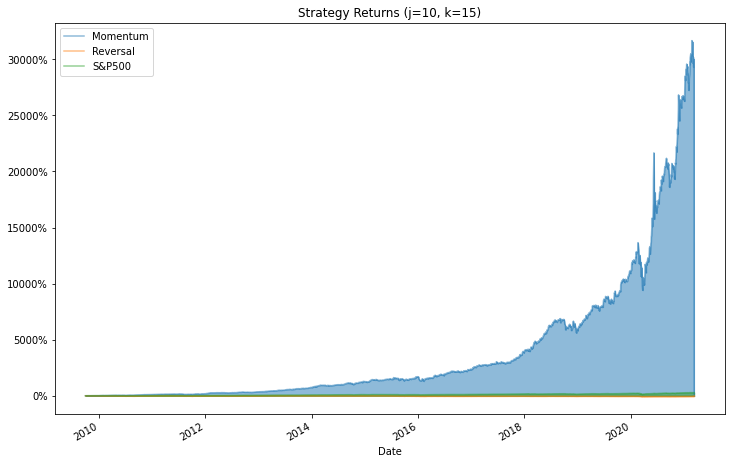

In [122]:
import matplotlib.ticker as mtick

fig = plt.figure(1, (12,8))
ax = fig.add_subplot(1,1,1)
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(xticks)
spc['pctc'] = spc['Adj Close'].pct_change()
spc['cumprod'] =((spc['pctc']+1).cumprod()-1)*100
sp500 = spc.merge(dpf, how='left', left_index=True, right_on='Date')
sp500[['Date', 'mom_return', 'rev_return','cumprod']].set_index('Date').plot.area(ax=ax,stacked=False,figsize=(12,8)) # plotted
ax.set_title('Strategy Returns (j='+str(j)+', k='+str(k)+")")
ax.legend(["Momentum", "Reversal", "S&P500"])
# fig.savefig('performance.png')

In [123]:
changes= sp500[['index','mom_pct_change', 'rev_pct_change','pctc']].rename(columns={'pctc':'SP500_pct_change'}).dropna()
changes.to_csv('daily_j'+str(j)+'_k'+str(k)+'_pct.csv')
changes

,index,mom_pct_change,rev_pct_change,SP500_pct_change
0.0,0.0,0.000000,0.000000,0.016043
1.0,0.0,0.027465,-0.004083,0.003116
2.0,0.0,0.023555,-0.018759,0.000546
3.0,0.0,0.073832,-0.004437,0.004001
4.0,0.0,-0.000327,-0.015054,0.002882
...,...,...,...,...
4077.0,270.0,-0.027041,-0.007218,-0.013417
4078.0,270.0,0.019691,0.027557,0.019496
4081.0,270.0,-0.031032,0.003927,-0.005359
4082.0,270.0,0.024760,0.003809,0.014155


In [124]:
sp500 = sp500.drop(['mom_return', 'rev_return'], axis=1) # mom_retunr and rev_return, beware of use
sp500 = sp500.reset_index(drop=True).set_index('Date')

sp500.ta.cci(length=4,append=True)
sp500.ta.kdj(length=4,append=True)
sp500.ta.rsi(length=4,append=True)
sp500.ta.bop(length=4,append=True)
sp500.ta.willr(length=4,append=True)
sp500.ta.pdist(length=4,append=True)
sp500.ta.kc(length=4,append=True)
sp500.ta.adx(length=4,append=True)
sp500.ta.qstick(length=4,append=True)
sp500.ta.roc(length=4,append=True)
# sp500.ta.ao(length=4,append=True)
# sp500.ta.macd(fast=4,slow=8,append=True)
sp500.ta.stdev(length=4,append=True)
sp500.ta.pvol(append=True)
sp500.ta.efi(length=4, append=True)
sp500 = sp500[sp500.index.isin(pd.date_range(timedf.j_start.min(), timedf.k_end.max()))]
sp500

,open,high,low,close,adj_close,volume,pctc,cumprod,index,mom_pct_change,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,0.000000,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,0.027465,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,0.023555,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,0.073832,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,-0.000327,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000,-0.005359,271.058910,270.0,-0.031032,...,3824.891827,3994.495880,41.137035,15.906452,28.289774,-17.252502,-1.264503,31.279697,2.236346e+13,-9.677543e+09
2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000,0.014155,276.311117,270.0,0.024760,...,3845.111072,4012.801434,32.350414,18.817021,21.215170,-0.307495,1.458745,44.822448,2.130074e+13,1.131119e+11
2021-03-10,3891.989990,3917.350098,3885.729980,3898.810059,3898.810059,5827250000,0.006030,278.580390,270.0,-0.007197,...,3866.590667,4000.733009,25.965217,20.790230,18.139277,13.912537,3.458700,34.462928,2.271934e+13,1.223406e+11


In [125]:
get_j_df = get_daily_j
get_k_df = get_daily_k
# get_j_df().groupby('period').count()


In [126]:
sp500 = sp500.dropna().reset_index()
sp500

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2021-03-04,3818.530029,3843.669922,3723.340088,3768.469971,3768.469971,7142240000,-0.013417,265.924170,270.0,...,3817.461671,3989.228356,40.559639,9.643459,52.792746,-17.092468,-1.119870,58.500739,2.691532e+13,-2.281458e+11
2811,2021-03-05,3793.580078,3851.689941,3730.189941,3841.939941,3841.939941,6842570000,0.019496,273.058216,270.0,...,3827.252979,4027.512990,45.509728,8.607734,34.821798,-19.830017,-1.534672,43.056661,2.628874e+13,6.420190e+10
2812,2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000,-0.005359,271.058910,270.0,...,3824.891827,3994.495880,41.137035,15.906452,28.289774,-17.252502,-1.264503,31.279697,2.236346e+13,-9.677543e+09
2813,2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000,0.014155,276.311117,270.0,...,3845.111072,4012.801434,32.350414,18.817021,21.215170,-0.307495,1.458745,44.822448,2.130074e+13,1.131119e+11


# START HERE! avoid most everything above

In [127]:
# df = pd.read_csv('SP500_daily.csv').infer_objects().dropna()
# def pull_data(j=10,k=20):
#     # this runs on bad code. Please restart the kernel and run all if you run into issues.
#     tdf, j, k = generate_daily_timetable(j=j,k=k)
#     df_ = pd.read_csv('daily_j'+str(j)+'_k'+str(k)+'.csv')
#     return tdf, df_, j, k
# timedf, df, j, k= pull_data(30,60)
df=sp500
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-01-28
1,2010-01-19,2010-01-29,2010-02-12
2,2010-02-03,2010-02-13,2010-02-27
3,2010-02-18,2010-02-28,2010-03-14
4,2010-03-05,2010-03-15,2010-03-29
...,...,...,...
267,2020-12-22,2021-01-01,2021-01-15
268,2021-01-06,2021-01-16,2021-01-30
269,2021-01-21,2021-01-31,2021-02-14
270,2021-02-05,2021-02-15,2021-03-01


In [128]:
df

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0.0,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0.0,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0.0,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0.0,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0.0,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2021-03-04,3818.530029,3843.669922,3723.340088,3768.469971,3768.469971,7142240000,-0.013417,265.924170,270.0,...,3817.461671,3989.228356,40.559639,9.643459,52.792746,-17.092468,-1.119870,58.500739,2.691532e+13,-2.281458e+11
2811,2021-03-05,3793.580078,3851.689941,3730.189941,3841.939941,3841.939941,6842570000,0.019496,273.058216,270.0,...,3827.252979,4027.512990,45.509728,8.607734,34.821798,-19.830017,-1.534672,43.056661,2.628874e+13,6.420190e+10
2812,2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000,-0.005359,271.058910,270.0,...,3824.891827,3994.495880,41.137035,15.906452,28.289774,-17.252502,-1.264503,31.279697,2.236346e+13,-9.677543e+09
2813,2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000,0.014155,276.311117,270.0,...,3845.111072,4012.801434,32.350414,18.817021,21.215170,-0.307495,1.458745,44.822448,2.130074e+13,1.131119e+11


In [129]:
df['index'] = df['index'].astype(int)
df # all the features you neeeed

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2021-03-04,3818.530029,3843.669922,3723.340088,3768.469971,3768.469971,7142240000,-0.013417,265.924170,270,...,3817.461671,3989.228356,40.559639,9.643459,52.792746,-17.092468,-1.119870,58.500739,2.691532e+13,-2.281458e+11
2811,2021-03-05,3793.580078,3851.689941,3730.189941,3841.939941,3841.939941,6842570000,0.019496,273.058216,270,...,3827.252979,4027.512990,45.509728,8.607734,34.821798,-19.830017,-1.534672,43.056661,2.628874e+13,6.420190e+10
2812,2021-03-08,3844.389893,3881.060059,3819.250000,3821.350098,3821.350098,5852240000,-0.005359,271.058910,270,...,3824.891827,3994.495880,41.137035,15.906452,28.289774,-17.252502,-1.264503,31.279697,2.236346e+13,-9.677543e+09
2813,2021-03-09,3851.929932,3903.760010,3851.929932,3875.439941,3875.439941,5496340000,0.014155,276.311117,270,...,3845.111072,4012.801434,32.350414,18.817021,21.215170,-0.307495,1.458745,44.822448,2.130074e+13,1.131119e+11


In [130]:
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-01-28
1,2010-01-19,2010-01-29,2010-02-12
2,2010-02-03,2010-02-13,2010-02-27
3,2010-02-18,2010-02-28,2010-03-14
4,2010-03-05,2010-03-15,2010-03-29
...,...,...,...
267,2020-12-22,2021-01-01,2021-01-15
268,2021-01-06,2021-01-16,2021-01-30
269,2021-01-21,2021-01-31,2021-02-14
270,2021-02-05,2021-02-15,2021-03-01


# Charting

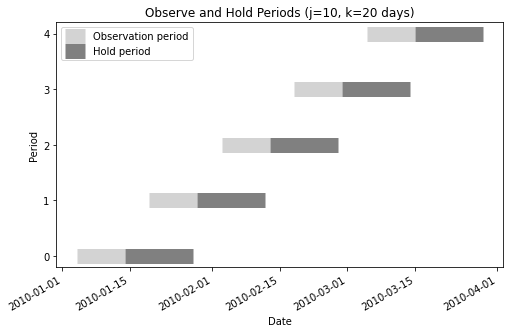

In [131]:
from matplotlib.dates import date2num
plotdf = df[df['index'] < 5][['index', 'date']]
plotdf['date'] = pd.to_datetime(plotdf['date'])

ax = plotdf.set_index('date').plot(figsize=(8, 5), title='Observe and Hold Periods (j=10, k=20 days)', yticks=[0,1,2,3,4], xlabel='Date', ylabel='Period')
ax.lines.pop(0)

for i in range(5):
    td = timedf.iloc[i]
    
    # ax.axvspan(td.j_start.strftime("%Y-%m-%d"), td.midpoint.strftime("%Y-%m-%d"), color='green', alpha=0.3)
    # ax.axvspan(td.midpoint.strftime("%Y-%m-%d"), td.k_end.strftime("%Y-%m-%d"), color='grey', alpha=0.3)
    ax.hlines(y=i, xmin=td.j_start.strftime("%Y-%m-%d"), xmax=td.midpoint.strftime("%Y-%m-%d"), linewidth=15, color='#d3d3d3', label='Observation period' if i==0 else '_nolegend_')
    ax.hlines(y=i,xmin=td.midpoint.strftime("%Y-%m-%d"), xmax=td.k_end.strftime("%Y-%m-%d"), linewidth=15, color='grey', label='Hold period' if i==0 else '_nolegend_')

ax.legend(loc='upper left')#.remove()
plt.show();


In [132]:
timedf.iloc[0].j_start.strftime("%Y-%m-%d")
timedf.iloc[0].midpoint.strftime("%Y-%m-%d")

'2010-01-14'

In [133]:
j0 = get_daily_j()
j0

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,period
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,2021-02-24,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,281.165221,270,...,4028.008469,37.971154,20.401993,37.856926,13.130005,0.292796,22.847885,2.332628e+13,8.020416e+10,271
2059,2021-02-25,3915.800049,3925.020020,3814.040039,3829.340088,3829.340088,6513060000,-0.024479,271.834751,270,...,4037.653031,41.723015,12.020612,39.107644,-4.872498,-1.980436,39.289060,2.494072e+13,-2.022131e+11,271
2060,2021-02-26,3839.659912,3861.080078,3789.540039,3811.149902,3811.149902,6512950000,-0.004750,270.068456,270,...,4004.283811,46.778655,8.892358,37.842591,-9.737488,-1.685802,51.803584,2.482183e+13,-1.687166e+11,271
2061,2021-03-01,3842.510010,3914.500000,3842.510010,3901.820068,3901.820068,5071540000,0.023791,278.872667,270,...,4045.978392,36.130237,23.181904,25.206970,-0.984985,0.526875,55.268977,1.978824e+13,8.270502e+10,271


In [134]:
def featurize(inputdf):
    df_ = inputdf.copy()
    df_['log_ret'] = np.log(df_['adj_close']) - np.log(df_['adj_close'].shift(1))
    df_['log_ret'] = df_['log_ret'].fillna(0)
    df_['adj_close_diff'] = df_['adj_close'].diff()
    df_['pctc'] = df_['adj_close'].pct_change().fillna(0)

    # df_['shifted_mom_pct_change'] = df_.mom_pct_change.shift()
    # df_['shifted_rev_pct_change'] = df_.rev_pct_change.shift()
    # df_['shifted_sp_pct_change'] = df_.pctc.shift()

    df_['cumprod'] = (df_['pctc']+1).cumprod()-1
    df_['mom_cumprod'] = (df_['mom_pct_change']+1).cumprod()-1
    df_['rev_cumprod'] = (df_['rev_pct_change']+1).cumprod()-1
    df_['SMA_5'] = df_['adj_close'].rolling(window=5).mean().fillna(method='bfill').fillna(0) #NOTE: changed from 10 to 5
    def label(mom_pct_ret,rev_pct_ret):
        if(mom_pct_ret > 0 and mom_pct_ret >= rev_pct_ret):
            return 1
        elif(mom_pct_ret < rev_pct_ret and rev_pct_ret > 0):
            return -1
        else:
            return 0

    def label_condition(rsi):
        if(rsi > 70.0):
            return 'OVERBOUGHT'
        elif(rsi < 30.0):
            return 'OVERSOLD'
        else:
            return 'NEUTRAL'
    # df_['movement'] = df_.apply(lambda x: label(x.mom_pct_change, x.rev_pct_change), axis=1).astype(int) # @amir i renamed your labels since i wasnt sure what this was
    df_['condition_OVERBOUGHT'] = (df['RSI_4'] > 70).astype(int)
    df_['condition_OVERSOLD'] = (df['RSI_4'] < 30).astype(int)
    df_['condition_NEUTRAL'] = ((df['RSI_4'] >= 30) & (df['RSI_4'] <= 70)).astype(int)
    label_value = 1 if df_.mom_cumprod.iloc[-1] > 0 and df_.mom_cumprod.iloc[-1] >= df_.rev_cumprod.iloc[-1] else -1 if df_.mom_cumprod.iloc[-1] < 0 and df_.rev_cumprod.iloc[-1] > 0 else 0 # returns the label value

    feat_vector = df_.agg( # here's the feature vector, a real chonker
        #encoded distribution information
        adj_close_mean=('adj_close',np.mean),
        adj_close_min =('adj_close',min),
        adj_close_max =('adj_close',max),
        adj_close_std =('adj_close',np.std),
        adj_close_diff_mean=('adj_close_diff',np.mean),
        adj_close_diff_min =('adj_close_diff',min),
        adj_close_diff_max =('adj_close_diff',max),
        adj_close_diff_std =('adj_close_diff',np.std),
        pct_chng_mean=('pctc',np.mean),
        pct_chng_min =('pctc',min),
        pct_chng_max =('pctc',max),
        pct_chng_std =('pctc',np.std),
        volume_mean=('volume',np.mean),
        volume_min =('volume',min),
        volume_max =('volume',max),
        volume_std =('volume',np.std),
        KCBe_4_2_mean=('KCBe_4_2',np.mean),
        KCBe_4_2_min =('KCBe_4_2',min),
        KCBe_4_2_max =('KCBe_4_2',max),
        KCBe_4_2_std =('KCBe_4_2',np.std),
        CCI_mean=('CCI_4_0.015',np.mean),
        CCI_min =('CCI_4_0.015',min),
        CCI_max =('CCI_4_0.015',max),
        CCI_std =('CCI_4_0.015',np.std),
        K_4_3_mean=('K_4_3',np.mean),
        K_4_3_min =('K_4_3',min),
        K_4_3_max =('K_4_3',max),
        K_4_3_std =('K_4_3',np.std),
        D_4_3_mean=('D_4_3',np.mean),
        D_4_3_min =('D_4_3',min),
        D_4_3_max =('D_4_3',max),
        D_4_3_std =('D_4_3',np.std),
        J_4_3_mean=('J_4_3',np.mean),
        J_4_3_min =('J_4_3',min),
        J_4_3_max =('J_4_3',max),
        J_4_3_std =('J_4_3',np.std),
        RSI_4_mean=('RSI_4',np.mean),
        RSI_4_min =('RSI_4',min),
        RSI_4_max =('RSI_4',max),
        RSI_4_std =('RSI_4',np.std),
        BOP_mean=('BOP',np.mean),
        BOP_min =('BOP',min),
        BOP_max =('BOP',max),
        BOP_std =('BOP',np.std),
        PDIST_mean=('PDIST',np.mean),
        PDIST_min =('PDIST',min),
        PDIST_max =('PDIST',max),
        PDIST_std =('PDIST',np.std),
        KCLe_4_2_mean=('KCLe_4_2',np.mean),
        KCLe_4_2_min =('KCLe_4_2',min),
        KCLe_4_2_max =('KCLe_4_2',max),
        KCLe_4_2_std =('KCLe_4_2',np.std),
        ADX_4_mean=('ADX_4',np.mean),
        ADX_4_min =('ADX_4',min),
        ADX_4_max =('ADX_4',max),
        ADX_4_std =('ADX_4',np.std),
        DMP_4_mean=('DMP_4',np.mean),
        DMP_4_min =('DMP_4',min),
        DMP_4_max =('DMP_4',max),
        DMP_4_std =('DMP_4',np.std),
        DMN_4_mean=('DMN_4',np.mean),
        DMN_4_min =('DMN_4',min),
        DMN_4_max =('DMN_4',max),
        DMN_4_std =('DMN_4',np.std),
        QS_4_mean=('QS_4',np.mean),
        QS_4_min =('QS_4',min),
        QS_4_max =('QS_4',max),
        QS_4_std =('QS_4',np.std),
        ROC_4_mean=('ROC_4',np.mean),
        ROC_4_min =('ROC_4',min),
        ROC_4_max =('ROC_4',max),
        ROC_4_std =('ROC_4',np.std),
        STDEV_4_mean=('STDEV_4',np.mean),
        STDEV_4_min =('STDEV_4',min),
        STDEV_4_max =('STDEV_4',max),
        STDEV_4_std =('STDEV_4',np.std),
        PVOL_mean=('PVOL',np.mean),
        PVOL_min =('PVOL',min),
        PVOL_max =('PVOL',max),
        PVOL_std =('PVOL',np.std),
        EFI_4_mean=('EFI_4',np.mean),
        EFI_4_min =('EFI_4',min),
        EFI_4_max =('EFI_4',max),
        EFI_4_std =('EFI_4',np.std),
        SMA_5_mean=('SMA_5',np.mean),
        SMA_5_min =('SMA_5',min),
        SMA_5_max =('SMA_5',max),
        SMA_5_std =('SMA_5',np.std),
        log_ret_mean=('log_ret',np.mean),
        log_ret_min =('log_ret',min),
        log_ret_max =('log_ret',max),
        log_ret_std =('log_ret',np.std),
        # getting last values
        cumprod_last=('cumprod', lambda x: x.iloc[-1]),
        mom_cumprod_last=('mom_cumprod', lambda x: x.iloc[-1]),
        rev_cumprod_last=('rev_cumprod', lambda x: x.iloc[-1]),
        log_ret_last=('log_ret', lambda x: x.iloc[-1]),
        #getting ratios. Watch for zero division errors.
        # movement_sell_mom_ratio=('movement', lambda x: (x==0).sum()/(x==1).sum()),
        # movement_rev_mom_ratio=('movement', lambda x: (x==-1).sum()/(x==1).sum()), # this breaks the function for some reason lol
        ).stack()
    feat_vector.index = feat_vector.index.droplevel(1) # dealing with multiindex shenanigans
    feat_vector = feat_vector.append(pd.Series({'label':label_value}))
    return feat_vector#, df_
# featvect0, outputdf = featurize(j0)
# featvect0
features = j0.groupby('index').apply(featurize)
features

,adj_close_mean,adj_close_min,adj_close_max,adj_close_std,adj_close_diff_mean,adj_close_diff_min,adj_close_diff_max,adj_close_diff_std,pct_chng_mean,pct_chng_min,...,SMA_5_std,log_ret_mean,log_ret_min,log_ret_max,log_ret_std,cumprod_last,mom_cumprod_last,rev_cumprod_last,log_ret_last,label
index,,,,,,,,,,,,,,,,,,,,,
0,1125.773531,1084.530029,1150.229980,23.519776,-3.028748,-24.719971,9.460083,10.280465,-0.002531,-0.022141,...,16.802497,-0.002571,-0.022390,0.008291,0.008927,-0.042772,0.242222,-0.142162,-0.011888,1.0
1,1072.202216,1056.739990,1097.280029,11.506594,0.205002,-34.170044,23.410034,17.424739,0.000271,-0.031141,...,2.248924,0.000170,-0.031636,0.021565,0.015110,0.001527,-0.025602,-0.053428,-0.002748,0.0
2,1104.457136,1094.599976,1109.170044,4.833409,-0.376668,-13.410034,10.640015,7.836872,-0.000274,-0.012103,...,0.658205,-0.000292,-0.012177,0.009674,0.006499,-0.002042,0.006389,0.002906,0.001404,1.0
3,1143.914978,1138.500000,1150.239990,5.446274,2.258008,-0.250000,5.160034,2.572678,0.001648,-0.000217,...,0.921828,0.001644,-0.000217,0.004514,0.002165,0.009915,0.041482,0.039549,-0.000217,1.0
4,1166.250000,1150.510010,1174.170044,7.765256,3.784993,-6.450073,15.300049,7.852182,0.002813,-0.005493,...,1.977637,0.002792,-0.005508,0.013211,0.006284,0.019739,0.048343,0.011859,0.005667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,3719.165039,3687.260010,3756.070068,23.875716,4.798584,-35.219971,32.300049,22.256410,0.001137,-0.009461,...,8.345951,0.001123,-0.009506,0.008685,0.005564,0.009024,0.020200,0.023504,0.006418,0.0
267,3793.880005,3748.139893,3824.679932,24.318272,2.872872,-27.290039,55.650146,29.242114,0.000692,-0.007190,...,5.398378,0.000669,-0.007216,0.014738,0.007156,0.005365,0.065920,0.067739,-0.007216,0.0
268,3807.415737,3714.239990,3855.360107,57.177755,-23.138346,-98.850098,36.609863,52.171285,-0.005159,-0.025678,...,14.601188,-0.005242,-0.026013,0.009713,0.012802,-0.036031,-0.051604,-0.047147,-0.019500,0.0


# train your models on this data ^^

In [135]:
j,k

(10, 15)

In [136]:
# features.to_csv('daily_j10_k20_features.csv')
# features.to_csv('daily_j20_k40_features.csv')
# features.to_csv('daily_j10_k10_features.csv')
features.to_csv('daily_j'+str(j)+'_k'+str(k)+'_features.csv')

In [137]:
timedf

,j_start,midpoint,k_end
0,2010-01-04,2010-01-14,2010-01-28
1,2010-01-19,2010-01-29,2010-02-12
2,2010-02-03,2010-02-13,2010-02-27
3,2010-02-18,2010-02-28,2010-03-14
4,2010-03-05,2010-03-15,2010-03-29
...,...,...,...
267,2020-12-22,2021-01-01,2021-01-15
268,2021-01-06,2021-01-16,2021-01-30
269,2021-01-21,2021-01-31,2021-02-14
270,2021-02-05,2021-02-15,2021-03-01


## --prototyping garbage below--

In [138]:
j0.columns

Index(['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'pctc',
       'cumprod', 'index', 'mom_pct_change', 'rev_pct_change', 'CCI_4_0.015',
       'K_4_3', 'D_4_3', 'J_4_3', 'RSI_4', 'BOP', 'WILLR_4', 'PDIST',
       'KCLe_4_2', 'KCBe_4_2', 'KCUe_4_2', 'ADX_4', 'DMP_4', 'DMN_4', 'QS_4',
       'ROC_4', 'STDEV_4', 'PVOL', 'EFI_4', 'period'],
      dtype='object')

In [139]:
(j0.mom_pct_change+1).cumprod()-1

0         0.000000
1         0.027465
2         0.051667
3         0.129314
4         0.128945
           ...    
2058    206.156723
2059    197.958886
2060    199.890788
2061    205.373828
2062    200.289549
Name: mom_pct_change, Length: 2063, dtype: float64

In [140]:
df_ = j0.copy()
df_['log_ret'] = np.log(df['adj_close']) - np.log(df['adj_close'].shift(1))
df_['log_ret'] = df_['log_ret'].fillna(0)
df_['adj_close_diff'] = df_['adj_close'].diff()
df_['shifted_mom_pct_change'] = df.mom_pct_change.shift()
df_['shifted_rev_pct_change'] = df.rev_pct_change.shift()
df_['shifted_sp_pct_change'] = df.pctc.shift()
df_['pctc'] = df_['adj_close'].pct_change().fillna(0)
df_['cumprod'] = (df_['pctc']+1).cumprod()-1
df_['mom_cumprod'] = (df_['mom_pct_change']+1).cumprod()-1
df_['rev_cumprod'] = (df_['rev_pct_change']+1).cumprod()-1
# df_['SMA_10'] = df['adj_close'].rolling(window=10).mean().fillna
def label(mom_pct_ret,rev_pct_ret):
    if(mom_pct_ret > 0 and mom_pct_ret >= rev_pct_ret):
        return 1
    elif(mom_pct_ret < rev_pct_ret and rev_pct_ret > 0):
        return -1
    else:
        return 0

def label_condition(rsi):
    if(rsi > 70.0):
        return 'OVERBOUGHT'
    elif(rsi < 30.0):
        return 'OVERSOLD'
    else:
        return 'NEUTRAL'
df_['label'] = df_.apply(lambda x: label(x.shifted_mom_pct_change, x.shifted_rev_pct_change), axis=1).astype(int)
df_['condition_OVERBOUGHT'] = (df['RSI_4'] > 70).astype(int)
df_['condition_OVERSOLD'] = (df['RSI_4'] < 30).astype(int)
df_['condition_NEUTRAL'] = ((df['RSI_4'] >= 30) & (df['RSI_4'] <= 70)).astype(int)
# df_['condition'] = df_.apply(lambda x: label_condition(x.RSI_4),axis=1)
# # y = 
# df_ = df_.merge(pd.get_dummies(df_.condition, prefix='condition'), left_index=True, right_index=True)
# df_ = df_.drop('condition',axis = 1)

df_

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,adj_close_diff,shifted_mom_pct_change,shifted_rev_pct_change,shifted_sp_pct_change,mom_cumprod,rev_cumprod,label,condition_OVERBOUGHT,condition_OVERSOLD,condition_NEUTRAL
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.000000,0.000000,0,...,NaN,NaN,NaN,NaN,0.000000,0.000000,0,0,0,1
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,0.003116,0,...,3.530029,0.000000,0.000000,0.016043,0.027465,-0.004083,0,1,0,0
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,0.003663,0,...,0.619995,0.027465,-0.004083,0.003116,0.051667,-0.022766,1,1,0,0
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,0.007679,0,...,4.549927,0.023555,-0.018759,0.000546,0.129314,-0.027102,1,1,0,0
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,0.010583,0,...,3.290039,0.073832,-0.004437,0.004001,0.128945,-0.041748,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2058,2021-02-24,3873.709961,3928.649902,3859.600098,3925.429932,3925.429932,5942350000,0.011352,2.464664,270,...,44.059814,0.003852,-0.001453,-0.000484,206.156723,-0.854602,1,0,0,1
2059,2021-02-25,3915.800049,3925.020020,3814.040039,3829.340088,3829.340088,6513060000,-0.024479,2.379853,270,...,-96.089844,-0.003373,0.004031,0.004463,197.958886,-0.856977,-1,1,0,0
2060,2021-02-26,3839.659912,3861.080078,3789.540039,3811.149902,3811.149902,6512950000,-0.004750,2.363798,270,...,-18.190186,0.013994,0.015513,0.017379,199.890788,-0.856925,-1,1,0,0
2061,2021-03-01,3842.510010,3914.500000,3842.510010,3901.820068,3901.820068,5071540000,0.023791,2.443826,270,...,90.670166,0.013131,0.007194,-0.001274,205.373828,-0.854609,1,0,0,1


In [141]:
df_.mom_cumprod.iloc[-1]

200.28954886838076

In [142]:
df_.mom_cumprod

0         0.000000
1         0.027465
2         0.051667
3         0.129314
4         0.128945
           ...    
2058    206.156723
2059    197.958886
2060    199.890788
2061    205.373828
2062    200.289549
Name: mom_cumprod, Length: 2063, dtype: float64

<AxesSubplot:xlabel='date'>

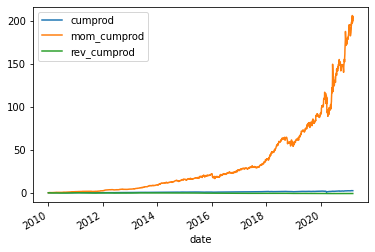

In [143]:
df_.set_index(pd.to_datetime(df_['date']))[['cumprod','mom_cumprod','rev_cumprod']].plot()

In [144]:
outputdf

NameError: name 'outputdf' is not defined

In [165]:
np.unique([get_daily_j(i).date.count() for i in range(204)]) # how many days are in each get_daily_j 

array([5, 6, 7, 8, 9])

In [166]:
[get_daily_k(i).date.count() for i in range(5)]

[13, 13, 14, 14, 15]

<AxesSubplot:>

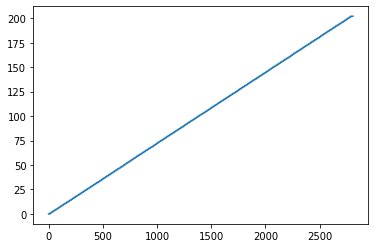

In [167]:
# df = sp500
get_daily_k()['index'].plot()

In [168]:
get_j_df(0).groupby('index').date.count()

index
0    9
Name: date, dtype: int64

In [169]:
per0 = get_j_df(0)
per0.head()

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,KCBe_4_2,KCUe_4_2,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,1125.862247,1150.908327,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,1130.125356,1150.728981,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,1132.931219,1149.485386,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,1136.434708,1155.279220,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,1139.852817,1158.495559,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10


In [170]:
per0['mom_cum_ret'] = (per0['mom_pct_change']+1).cumprod()-1
per0['rev_cum_ret'] = (per0['rev_pct_change']+1).cumprod()-1
per0

,date,open,high,low,close,adj_close,volume,pctc,cumprod,index,...,ADX_4,DMP_4,DMN_4,QS_4,ROC_4,STDEV_4,PVOL,EFI_4,mom_cum_ret,rev_cum_ret
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000,0.016043,10.015052,0,...,31.353875,25.824193,20.473821,0.867462,0.461966,7.420261,4.522216e+12,2.361978e+10,0.000000,0.000000
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,10.357824,0,...,29.868441,28.282059,16.820527,2.419983,0.916362,9.419172,2.831094e+12,1.768922e+10,0.027465,-0.004083
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,10.418026,0,...,31.780718,31.403334,14.268415,2.554993,0.951685,10.387101,5.654611e+12,1.184674e+10,0.051667,-0.022766
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,10.859831,0,...,36.597717,30.786961,9.977320,6.784973,2.384536,3.572899,6.017482e+12,1.670053e+10,0.129314,-0.027102
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,11.179299,0,...,42.725905,31.076194,7.501304,3.792480,1.058261,3.996610,5.025993e+12,1.579709e+10,0.128945,-0.041748
5,2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,0.001747,11.373502,0,...,50.133800,36.581995,5.866983,3.082489,0.920350,4.299231,4.881294e+12,1.288288e+10,0.152255,-0.055975
6,2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4716160000,-0.009381,10.328688,0,...,40.024110,23.266002,28.261626,0.827454,-0.080909,4.701463,5.358595e+12,-1.256865e+10,0.175668,-0.090007
7,2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4170360000,0.008326,11.247277,0,...,33.664016,25.518823,19.022968,1.564972,0.349492,4.900584,4.777898e+12,8.239593e+09,0.202810,-0.084555
8,2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000,0.002426,11.517210,0,...,31.337741,26.297119,15.995175,1.144958,0.303934,5.527932,4.496450e+12,9.297313e+09,0.236339,-0.098202


leptokurtic distribution
the only things we can do is buy, hold, or leave for rev or momentum
<br><br>choices:
- momentum
- reversal
- neither